In [1]:
import numpy             as np
import pandas            as pd
import pytorch_lightning as pl
import ML_library        as MLL
import matplotlib.pyplot as plt
import matgl
import os
import warnings
import glob

from __future__                import annotations
from pytorch_lightning.loggers import CSVLogger
from matgl.ext.pymatgen        import Structure2Graph, get_element_list
from matgl.graph.data          import M3GNetDataset, MGLDataLoader, collate_fn_efs
from matgl.utils.training      import PotentialLightningModule

# To suppress warnings for clearer output
warnings.simplefilter('ignore')

In [12]:
data_train_path = 'm3gnet_dataset.xlsx'
model_load_path = 'M3GNet-MP-2021.2.8-PES'
model_save_path = 'finetuned_model'

# Whether to include charge or not
charged = False

# 0: material, 1: charge state, 2: ionic step
depth = 1

# Stress weight for training
stress_weight = 0

# Ratios for diving training data
test_ratio       = 0.2
validation_ratio = 0.2

# Number of epoch for re-training
max_epochs = 10

# Learning-rate for re-training
lr = 1e-4

dpi = 100

# Version of trainng you specifically want to analyze
current_version = 1

# Load simulation data

In [3]:
# Each folder names a new column, and structure, energy, forces and stresses
# of each ionic step are loaded

max_counter = 0
if os.path.exists(data_train_path):
    # Load data for model training
    m3gnet_dataset = pd.read_excel(data_train_path, index_col=0, header=[0,1,2])
else:
    if max_counter < 100:
        # Path to dataset, structured as:
        # path_to_dataset
        #     material_i
        #         defect_i
        #             simulation_i (containing vasprun.xml)
        path_to_dataset = '../../../Desktop/defects/gamma'

        # Extract the data
        source_m3gnet_dataset = MLL.extract_vaspruns_dataset(path_to_dataset, charged=charged)
        #source_m3gnet_dataset.to_excel(data_train_path)
    max_counter += 1

source_m3gnet_dataset


BiSBr

BiSeBr

BiSeI

BiSI
	as_1_Bi_on_S_-1
	as_1_Bi_on_S_-2
	as_1_Bi_on_S_0
	as_1_Bi_on_S_1
	as_1_Bi_on_S_2
	as_1_Bi_on_S_3
	as_1_Bi_on_S_4
	as_1_Bi_on_S_5
	as_1_I_on_Bi_-1
	as_1_I_on_Bi_-2
	as_1_I_on_Bi_0
	as_1_I_on_Bi_1
	as_1_I_on_Bi_2
	as_1_I_on_Bi_3
	as_1_I_on_Bi_4
	as_1_I_on_Bi_5
	as_1_S_on_Bi_-1
	as_1_S_on_Bi_-2
	as_1_S_on_Bi_0
	as_1_S_on_Bi_1
	as_1_S_on_Bi_2
	as_1_S_on_Bi_3
	as_1_S_on_Bi_4
	as_1_S_on_Bi_5
	as_2_Bi_on_I_-1
	as_2_Bi_on_I_-2
	as_2_Bi_on_I_0
	as_2_Bi_on_I_1
	as_2_Bi_on_I_2
	as_2_Bi_on_I_3
	as_2_Bi_on_I_4
	as_2_Bi_on_I_5
	as_2_I_on_S_-1
	as_2_I_on_S_-2
	as_2_I_on_S_0
	as_2_I_on_S_1
	as_2_I_on_S_2
	as_2_I_on_S_3
	as_2_I_on_S_4
	as_2_I_on_S_5
	as_2_S_on_I_-1
	as_2_S_on_I_-2
	as_2_S_on_I_0
	as_2_S_on_I_1
	as_2_S_on_I_2
	as_2_S_on_I_3
	as_2_S_on_I_4
	as_2_S_on_I_5
	vac_1_Bi_-1
	vac_1_Bi_-2
	vac_1_Bi_-3
	vac_1_Bi_0
	vac_1_Bi_1
	vac_1_Bi_2
	vac_1_Bi_3
	vac_2_S_-1
	vac_2_S_-2
	vac_2_S_0
	vac_2_S_1
	vac_2_S_2
	vac_3_I_-1
	vac_3_I_0
	vac_3_I_1


BiSI  \
                                         BiSI_as_1_Bi_on_S_0   
                                       BiSI_as_1_Bi_on_S_0_0   
structure  [[3.15281399 2.93861474 5.6361836 ] Bi, [0.840...   
energy                                           -294.774851   
force      [[0.57736977, -1.63242556, 1.17957877], [1.322...   
stress     [[-8.98107491, 1.103581288, -0.33427516], [1.1...   
nelect                                                   0.0   

                                                              \
                                                               
                                       BiSI_as_1_Bi_on_S_0_1   
structure  [[3.18066794 2.85986214 5.69308968] Bi, [0.904...   
energy                                           -319.917488   
force      [[0.45092731, -0.5269289, 0.95785729], [0.5906...   
stress     [[-1.3134776920000002, 1.015722362, -0.7020574...   
nelect                                                   0.0   

                                                              \
                                                               
                                       BiSI_as_1_Bi_on_S_0_2   
structure  [[3.18186462 2.85647853 5.69553475] Bi, [0.907...   
energy                                           -320.040468   
force      [[0.44652827, -0.50201233, 0.93817474], [0.572...   
stress     [[-1.198952454, 0.9700371680000001, -0.6768854...   
nelect                                                   0.0   

                                                              \
                                                               
                                       BiSI_as_1_Bi_on_S_0_3   
structure  [[3.18425824 2.84971096 5.70042489] Bi, [0.912...   
energy                                           -320.176804   
force      [[0.45916994, -0.4505556, 0.92291644], [0.5390...   
stress     [[-1.005328297, 0.888548823, -0.627759971], [0...   
nelect                                                   0.0   

                                                              \
                                                               
                                       BiSI_as_1_Bi_on_S_0_4   
structure  [[3.20900793 2.82168357 5.75023791] Bi, [0.944...   
energy                                           -325.624852   
force      [[0.19563511, -0.25673984, 0.545946], [0.41148...   
stress     [[-0.2772717, 0.696213823, -0.617854017], [0.6...   
nelect                                                   0.0   

                                                              \
                                                               
                                       BiSI_as_1_Bi_on_S_0_5   
structure  [[3.25263881 2.77227422 5.83805264] Bi, [0.999...   
energy                                           -329.103769   
force      [[-0.16774403, -0.03047637, 0.00970247], [0.46...   
stress     [[-0.054385977, 0.358665369, -0.58234967700000...   
nelect                                                   0.0   

                                                              \
                                                               
                                       BiSI_as_1_Bi_on_S_0_6   
structure  [[3.53506166 3.02120201 5.97543895] Bi, [0.936...   
energy                                           -327.769206   
force      [[-0.94326306, -0.74277117, -0.89198431], [1.3...   
stress     [[0.238542204, 0.33983066100000003, -0.3729511...   
nelect                                                   0.0   

                                                              \
                                                               
                                       BiSI_as_1_Bi_on_S_0_7   
structure  [[3.32964583 2.66404024 6.01978794] Bi, [0.994...   
energy                                           -331.530127   
force      [[-0.22859606, -0.06270516, -0.00857481], [0.1...   
stress     [[0.042113925, 0.295679982, -0.268763702], [0....   
nelect           

In [4]:
len(source_m3gnet_dataset)

5

# Split data into train-validation-test sets

### Decide if we split in terms of mateiral, defect state or simulation directly

In [6]:
# Clone (copy) the DataFrame
m3gnet_dataset = source_m3gnet_dataset.copy()

# Remove the outer (top-level) column index up to depth-1 level
for i in range(depth):
    m3gnet_dataset.columns = m3gnet_dataset.columns.droplevel(0)

In [9]:
m3gnet_dataset

BiSI_as_1_Bi_on_S_0  \
                                       BiSI_as_1_Bi_on_S_0_0   
structure  [[3.15281399 2.93861474 5.6361836 ] Bi, [0.840...   
energy                                           -294.774851   
force      [[0.57736977, -1.63242556, 1.17957877], [1.322...   
stress     [[-8.98107491, 1.103581288, -0.33427516], [1.1...   
nelect                                                   0.0   

                                                              \
                                       BiSI_as_1_Bi_on_S_0_1   
structure  [[3.18066794 2.85986214 5.69308968] Bi, [0.904...   
energy                                           -319.917488   
force      [[0.45092731, -0.5269289, 0.95785729], [0.5906...   
stress     [[-1.3134776920000002, 1.015722362, -0.7020574...   
nelect                                                   0.0   

                                                              \
                                       BiSI_as_1_Bi_on_S_0_2   
structure  [[3.18186462 2.85647853 5.69553475] Bi, [0.907...   
energy                                           -320.040468   
force      [[0.44652827, -0.50201233, 0.93817474], [0.572...   
stress     [[-1.198952454, 0.9700371680000001, -0.6768854...   
nelect                                                   0.0   

                                                              \
                                       BiSI_as_1_Bi_on_S_0_3   
structure  [[3.18425824 2.84971096 5.70042489] Bi, [0.912...   
energy                                           -320.176804   
force      [[0.45916994, -0.4505556, 0.92291644], [0.5390...   
stress     [[-1.005328297, 0.888548823, -0.627759971], [0...   
nelect                                                   0.0   

                                                              \
                                       BiSI_as_1_Bi_on_S_0_4   
structure  [[3.20900793 2.82168357 5.75023791] Bi, [0.944...   
energy                                           -325.624852   
force      [[0.19563511, -0.25673984, 0.545946], [0.41148...   
stress     [[-0.2772717, 0.696213823, -0.617854017], [0.6...   
nelect                                                   0.0   

                                                              \
                                       BiSI_as_1_Bi_on_S_0_5   
structure  [[3.25263881 2.77227422 5.83805264] Bi, [0.999...   
energy                                           -329.103769   
force      [[-0.16774403, -0.03047637, 0.00970247], [0.46...   
stress     [[-0.054385977, 0.358665369, -0.58234967700000...   
nelect                                                   0.0   

                                                              \
                                       BiSI_as_1_Bi_on_S_0_6   
structure  [[3.53506166 3.02120201 5.97543895] Bi, [0.936...   
energy                                           -327.769206   
force      [[-0.94326306, -0.74277117, -0.89198431], [1.3...   
stress     [[0.238542204, 0.33983066100000003, -0.3729511...   
nelect                                                   0.0   

                                                              \
                                       BiSI_as_1_Bi_on_S_0_7   
structure  [[3.32964583 2.66404024 6.01978794] Bi, [0.994...   
energy                                           -331.530127   
force      [[-0.22859606, -0.06270516, -0.00857481], [0.1...   
stress     [[0.042113925, 0.295679982, -0.268763702], [0....   
nelect                                                   0.0   

                                                              \
                                       BiSI_as_1_Bi_on_S_0_8   
structure  [[3.19835354 2.99697337 5.39773103] Bi, [0.840...   
energy                                           -329.474094   
force      [[-1.04273274, -0.10041773, 1.31242829], [0.32...   
stress     [[0.6487487670000001, 0.329506073, -0.13418057...   
nelect                                                   0.0   



### Splitting into train-validation-test sets

In [13]:
# Check if data has been already split, else do it randomly

path_to_test_labels       = 'test_labels.txt'
path_to_validation_labels = 'validation_labels.txt'
path_to_train_labels      = 'train_labels.txt'

if path.exists(path_to_test_labels) and path.exists(path_to_validation_labels) and path.exists(path_to_train_labels):
    # Read labels splitting (which are strings)
    test_labels       = np.genfromtxt(path_to_test_labels,       dtype='str').tolist()
    validation_labels = np.genfromtxt(path_to_validation_labels, dtype='str').tolist()
    train_labels      = np.genfromtxt(path_to_train_labels,      dtype='str').tolist()
else:
    # Define unique labels, wrt the outer column
    unique_labels = np.unique(m3gnet_dataset.columns.get_level_values(0))

    # Shuffle the list of unique labels
    np.random.shuffle(unique_labels)

    # Define the sizes of every sets
    # Corresponds to the size wrt the number of unique materials in the dataset
    test_size       = int(test_ratio       * len(unique_labels))
    validation_size = int(validation_ratio * len(unique_labels))

    test_labels       = unique_labels[:test_size]
    validation_labels = unique_labels[test_size:test_size+validation_size]
    train_labels      = unique_labels[test_size+validation_size:]
    
    # Save this splitting for tranfer-learning approaches
    np.savetxt(path_to_test_labels,       test_labels,       fmt='%s')
    np.savetxt(path_to_validation_labels, validation_labels, fmt='%s')
    np.savetxt(path_to_train_labels,      train_labels,      fmt='%s')

# Use the loaded/computed labels to generate split datasets
test_dataset       = m3gnet_dataset[test_labels]
validation_dataset = m3gnet_dataset[validation_labels]
train_dataset      = m3gnet_dataset[train_labels]

n_test       = np.shape(test_dataset)[1]
n_validation = np.shape(validation_dataset)[1]
n_train      = np.shape(train_dataset)[1]

print(f'Using {n_train} samples to train, {n_validation} to evaluate, and {n_test} to test')

Using 1993 samples to train, 300 to evaluate, and 240 to test


### Convert into graph database

In [17]:
all_data = []
for i in range(3):  # Iterate over train-validation-test sets
    name    = ['train', 'val', 'test'][i]
    dataset = [train_dataset, validation_dataset, test_dataset][i]
    
    # Extract data from dataset
    structures    = dataset.loc['structure'].values.tolist()
    element_types = get_element_list(structures)
    converter     = Structure2Graph(element_types=element_types, cutoff=5.0)
    
    # Define data labels from dataset
    labels = {
        'energies': dataset.loc['energy'].values.tolist(),
        'forces':   dataset.loc['force'].values.tolist(),
        'stresses': dataset.loc['stress'].values.tolist(),
    }
    
    graph_labels = None
    if charged:
        graph_labels = {
            'charge': dataset.loc['nelect'].values.tolist()
        }
    
    # Generate dataset
    data = M3GNetDataset(
        filename=f'dgl_graph-{name}.bin',
        filename_line_graph=f'dgl_line_graph-{name}.bin',
        filename_state_attr=f'state_attr-{name}.pt',
        filename_labels=f'labels-{name}.json',
        threebody_cutoff=4.0,
        structures=structures,
        converter=converter,
        labels=labels,
        graph_labels=graph_labels,  # dataset.loc['nelect'].values.tolist(),
        name=f'M3GNetDataset-{name}',
    )
    all_data.append(data)

train_data, val_data, test_data = all_data

100%|████████████████████████████████████████| 240/240 [00:02<00:00, 105.43it/s]


In [18]:
train_loader, val_loader, test_loader = MGLDataLoader(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    collate_fn=collate_fn_efs,
    batch_size=2,
    num_workers=1,
)

# Retrain model

In [23]:
# Download a pre-trained M3GNet
m3gnet_nnp       = matgl.load_model(model_load_path)
model_pretrained = m3gnet_nnp.model

# Stress and site-wise are added to training loss
# Stresses are being computed (calc_stress=True)
lit_module_finetune = PotentialLightningModule(model=model_pretrained,
                                               stress_weight=stress_weight,
                                               loss='mse_loss',
                                               lr=lr)

In [24]:
# If you wish to disable GPU or MPS (M1 mac) training, use the accelerator='cpu' kwarg.
# accelerator='auto' selects the appropriate Accelerator
logger  = CSVLogger('logs',
                    name='M3GNet_finetuning')

trainer = pl.Trainer(max_epochs=max_epochs,
                     accelerator='auto',
                     logger=logger,
                     inference_mode=False)

trainer.fit(model=lit_module_finetune,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader
           )

# Save trained model
model_pretrained.save(model_save_path)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | mae   | MeanAbsoluteError | 0     
1 | rmse  | MeanSquaredError  | 0     
2 | model | Potential         | 288 K 
--------------------------------------------
288 K     Trainable params
0         Non-trainable params
288 K     Total params
1.153     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


# Analyze metrics

In [25]:
# E_MAE = meV/atom, F_MAE eV/A, S_MAE GPa
trainer.test(model=lit_module_finetune,
            dataloaders=test_loader
           )

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_Energy_MAE        0.07995457202196121
    test_Energy_RMSE        0.08003398776054382
     test_Force_MAE         0.05949908494949341
     test_Force_RMSE        0.09259666502475739
   test_Site_Wise_MAE               0.0
   test_Site_Wise_RMSE              0.0
     test_Stress_MAE        0.11437420547008514
    test_Stress_RMSE        0.1532202512025833
     test_Total_Loss        0.02438202127814293
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_Total_Loss': 0.02438202127814293,
  'test_Energy_MAE': 0.07995457202196121,
  'test_Force_MAE': 0.05949908494949341,
  'test_Stress_MAE': 0.11437420547008514,
  'test_Site_Wise_MAE': 0.0,
  'test_Energy_RMSE': 0.08003398776054382,
  'test_Force_RMSE': 0.09259666502475739,
  'test_Stress_RMSE': 0.1532202512025833,
  'test_Site_Wise_RMSE': 0.0}]

In [26]:
# Read the CSV file
path_to_csv = f'logs/M3GNet_finetuning/version_{current_version}'
df = pd.read_csv(f'{path_to_csv}/metrics.csv')
df.head()

,val_Total_Loss,val_Energy_MAE,val_Force_MAE,val_Stress_MAE,val_Site_Wise_MAE,val_Energy_RMSE,val_Force_RMSE,val_Stress_RMSE,val_Site_Wise_RMSE,epoch,...,train_Site_Wise_RMSE,test_Total_Loss,test_Energy_MAE,test_Force_MAE,test_Stress_MAE,test_Site_Wise_MAE,test_Energy_RMSE,test_Force_RMSE,test_Stress_RMSE,test_Site_Wise_RMSE
0,0.705507,0.188376,0.174930,0.437609,0.0,0.188572,0.248715,0.661342,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.562400,0.208729,0.179449,0.389730,0.0,0.208842,0.253771,0.575714,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.456552,0.185475,0.179377,0.342890,0.0,0.185660,0.253601,0.499900,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# NaN to zero
df = df.fillna(0)

# Calculate the sum of every two consecutive rows
df = df.groupby(df.index // 2).sum()
df.head()

,val_Total_Loss,val_Energy_MAE,val_Force_MAE,val_Stress_MAE,val_Site_Wise_MAE,val_Energy_RMSE,val_Force_RMSE,val_Stress_RMSE,val_Site_Wise_RMSE,epoch,...,train_Site_Wise_RMSE,test_Total_Loss,test_Energy_MAE,test_Force_MAE,test_Stress_MAE,test_Site_Wise_MAE,test_Energy_RMSE,test_Force_RMSE,test_Stress_RMSE,test_Site_Wise_RMSE
0,1.267907,0.397105,0.354379,0.827339,0.0,0.397413,0.502487,1.237056,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.830436,0.372079,0.346358,0.624172,0.0,0.372458,0.499177,0.903034,0.0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.900463,0.414587,0.336276,0.642153,0.0,0.414811,0.494001,0.936268,0.0,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.777921,0.342063,0.291470,0.579513,0.0,0.342294,0.428744,0.853787,0.0,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.786014,0.368541,0.275510,0.602647,0.0,0.368791,0.403763,0.895537,0.0,34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


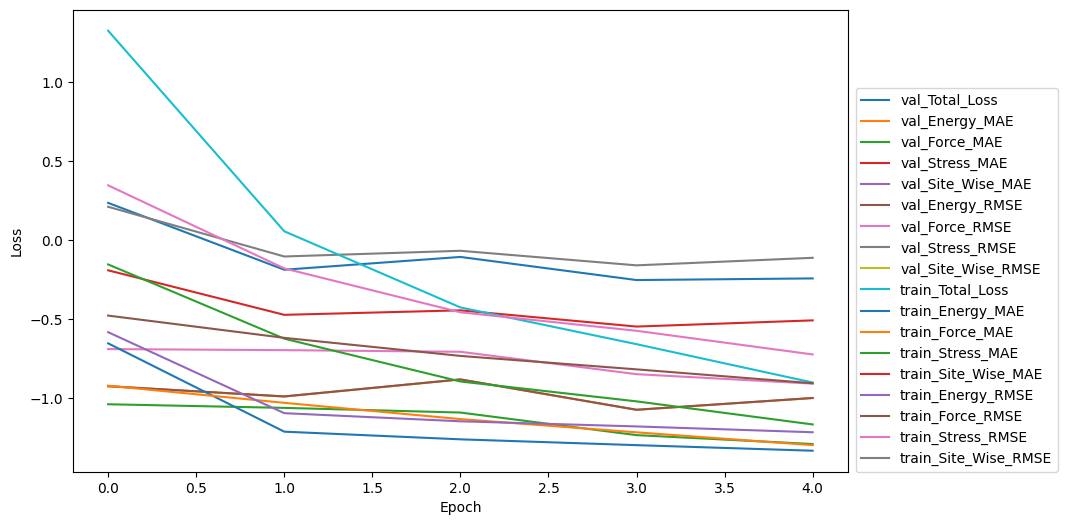

In [32]:
# Get the list of loss column names
loss_columns = [col for col in df.columns if col.startswith('val_') or col.startswith('train_')]

# Create a figure and axis
fig = plt.subplots(figsize=(10, 6))

# Plot each loss
for loss_column in loss_columns:
    plt.plot(df.index, np.log(df[loss_column]), label=loss_column)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=(1.01, 0))
plt.savefig(f'm3gnet_loss.eps', dpi=dpi, bbox_inches='tight')
plt.show()

In [33]:
df['val_Energy_MAE'].iloc[-2], df['val_Force_MAE'].iloc[-2], df['val_Stress_MAE'].iloc[-2]

(0.3685409277677536, 0.2755101323127745, 0.6026471555233002)

In [34]:
df['val_Energy_MAE'].iloc[-1], df['val_Force_MAE'].iloc[-1], df['val_Stress_MAE'].iloc[-1]

(0.0, 0.0, 0.0)

# Cleanup the notebook

In [35]:
# This code just performs cleanup for this notebook from temporal files

patterns = ['dgl_graph*.bin', 'dgl_line_graph*.bin', 'state_attr*.pt', 'labels*.json']
for pattern in patterns:
    files = glob.glob(pattern)
    for file in files:
        try:
            os.remove(file)
        except FileNotFoundError:
            pass

#shutil.rmtree('logs')
#shutil.rmtree('trained_model')
#shutil.rmtree('finetuned_model')